In [1]:
import tushare as ts

In [2]:
ts.get_k_data('399300', index=True,start='2016-10-01', end='2016-10-31')

date     open    close     high      low       volume      code
184  2016-10-10  3265.36  3293.87  3294.64  3258.96   80519260.0  sz399300
185  2016-10-11  3296.87  3306.56  3308.00  3292.88   87713163.0  sz399300
186  2016-10-12  3299.14  3300.01  3302.56  3289.75   68669781.0  sz399300
187  2016-10-13  3299.16  3302.65  3307.41  3292.40   81224198.0  sz399300
188  2016-10-14  3298.73  3305.85  3306.69  3285.73   82316271.0  sz399300
189  2016-10-17  3305.96  3277.88  3309.01  3271.54   86113509.0  sz399300
190  2016-10-18  3272.68  3321.33  3321.33  3272.68  102860714.0  sz399300
191  2016-10-19  3323.30  3316.24  3332.52  3309.83  101167725.0  sz399300
192  2016-10-20  3317.18  3318.60  3324.90  3312.17   79238871.0  sz399300
193  2016-10-21  3315.72  3327.74  3341.56  3309.18  109785176.0  sz399300
194  2016-10-24  3332.51  3367.58  3382.83  3330.97  153014345.0  sz399300
195  2016-10-25  3367.48  3367.45  3373.91  3356.59  111191693.0  sz399300
196  2016-10-26  3365.20  3354.80  3367.83  3349.57   98024786.0  sz399300
197  2016-10-27  3351.46  3345.70  3352.35  3335.13   77629851.0  sz399300
198  2016-10-28  3347.14  3340.13  3370.75  3337.29   93133309.0  sz399300
199  2016-10-31  3332.41  3336.28  3340.47  3317.33   71352863.0  sz399300

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import pandas_datareader.data as web
import h5py

In [3]:
#df=ts.get_k_data('399300', index=True,start='1950-10-01', end='2017-5-28')

In [8]:
import pickle

In [87]:
f = open('399300.bin', 'wb')
pickle.dump(df, f)
f.close()

In [8]:
f = open('399300.bin', 'rb')
df = pickle.load(f)
f.close()

In [89]:
stock_name = '399300'
seq_len = 22
d = 0.3
shape = [4, seq_len, 1] # feature, window, output
neurons = [256, 256, 64, 1]
epochs = 70

In [91]:
def get_stock_data(stock_name, normalize=True):
    #start = datetime.datetime(1950, 1, 1)
    #end = datetime.date.today()
    df = ts.get_k_data(stock_name, index=True,start='1950-10-01', end='2017-5-28')
    df.drop(['volume', 'code'], 1, inplace=True)
    
    if normalize:        
        min_max_scaler = preprocessing.MinMaxScaler()
        df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
        df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
        df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
        df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
    return df

In [92]:
df = get_stock_data(stock_name, normalize=True)

In [93]:
def plot_stock(stock_name):
    df = get_stock_data(stock_name, normalize=True)
    print(df.head())
    plt.plot(df['close'], color='red', label='close')
    plt.legend(loc='best')
    plt.show()

         date      open     close      high       low
0  2005-04-08  0.033317  0.036650  0.035486  0.034296
1  2005-04-11  0.037126  0.035063  0.036479  0.036940
2  2005-04-12  0.035110  0.031758  0.033515  0.034031
3  2005-04-13  0.033969  0.036146  0.036039  0.035978
4  2005-04-14  0.037276  0.033393  0.036023  0.035504


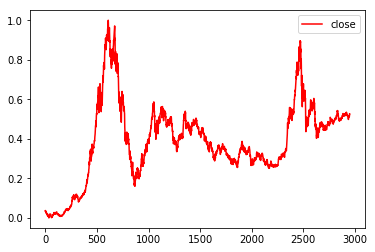

In [94]:
plot_stock(stock_name)

In [95]:
def load_data(stock, seq_len):
    stock = stock[['open','high','low','close']]
    amount_of_features = len(stock.columns)
    data = stock.as_matrix()#[:,1:]
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days
    
    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% split
    
    train = result[:int(row), :] # 90% date
    X_train = train[:, :-1] # all data until day m
    y_train = train[:, -1][:,-1] # day m + 1 adjusted close price
    
    X_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1] 

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test]
X_train, y_train, X_test, y_test = load_data(df, seq_len)

In [96]:
X_train.shape[0], X_train.shape[1], X_train.shape[2], y_train.shape[0]

(2634, 22, 4, 2634)

In [97]:
def build_model2(layers, neurons, d):
    model = Sequential()
    
    model.add(LSTM(neurons[0], input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(neurons[1], input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))
    # model = load_model('my_LSTM_stock_model1000.h5')
    adam = keras.optimizers.Adam(decay=0.3) #tobe analysed
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [98]:
model = build_model2(shape, neurons, d)
# layers = [4, 22, 1]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_97 (LSTM)               (None, 22, 256)           267264    
_________________________________________________________________
dropout_97 (Dropout)         (None, 22, 256)           0         
_________________________________________________________________
lstm_98 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_98 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_97 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_98 (Dense)             (None, 1)                 65        
Total params: 809,089
Trainable params: 809,089
Non-trainable params: 0
_________________________________________________________________


In [99]:
model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=epochs,
    validation_split=0.1,
    verbose=1)

Train on 2370 samples, validate on 264 samples
Epoch 1/70
2370/2370 [==============================] - 8s - loss: 0.1336 - acc: 4.2194e-04 - val_loss: 0.0119 - val_acc: 0.0000e+00
Epoch 2/70
2370/2370 [==============================] - 0s - loss: 0.0381 - acc: 4.2194e-04 - val_loss: 0.0910 - val_acc: 0.0000e+00
Epoch 3/70
2370/2370 [==============================] - 0s - loss: 0.0388 - acc: 4.2194e-04 - val_loss: 0.0466 - val_acc: 0.0000e+00
Epoch 4/70
2370/2370 [==============================] - 0s - loss: 0.0150 - acc: 8.4388e-04 - val_loss: 0.0099 - val_acc: 0.0000e+00
Epoch 5/70
2370/2370 [==============================] - 0s - loss: 0.0158 - acc: 8.4388e-04 - val_loss: 0.0329 - val_acc: 0.0000e+00
Epoch 6/70
2370/2370 [==============================] - 0s - loss: 0.0133 - acc: 8.4388e-04 - val_loss: 0.0272 - val_acc: 0.0000e+00
Epoch 7/70
2370/2370 [==============================] - 0s - loss: 0.0084 - acc: 8.4388e-04 - val_loss: 0.0067 - val_acc: 0.0000e+00
Epoch 8/70
2370/2370 [

In [100]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]
model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00066 MSE (0.03 RMSE)
Test Score: 0.00016 MSE (0.01 RMSE)


(0.0006570576087354407, 0.0001631652159426034)

In [101]:
def percentage_difference(model, X_test, y_test):
    percentage_diff=[]

    p = model.predict(X_test)
    for u in range(len(y_test)): # for each data index in test data
        pr = p[u][0] # pr = prediction on day u

        percentage_diff.append((pr-y_test[u]/pr)*100)
    return p
p = percentage_difference(model, X_test, y_test)

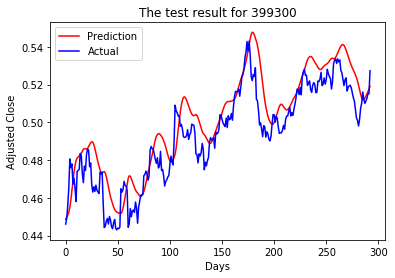

In [102]:
def denormalize(stock_name, normalized_value):
    #start = datetime.datetime(2000, 1, 1)
    #end = datetime.date.today()
    #df = web.DataReader(stock_name, "yahoo", start, end)
    
    df1 = df['close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df1)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new
def plot_result(stock_name, normalized_value_p, normalized_value_y_test):
    newp = denormalize(stock_name, normalized_value_p)
    newy_test = denormalize(stock_name, normalized_value_y_test)
    plt2.plot(newp, color='red', label='Prediction')
    plt2.plot(newy_test,color='blue', label='Actual')
    plt2.legend(loc='best')
    plt2.title('The test result for {}'.format(stock_name))
    plt2.xlabel('Days')
    plt2.ylabel('Adjusted Close')
    plt2.show()
plot_result(stock_name, p, y_test)

In [103]:
model.save('LSTM_Stock_prediction-20170528.h5')

In [65]:
stock_name = '399300'
seq_len = 22
d = 0.2
shape = [4, seq_len, 1] # feature, window, output
neurons = [128, 128, 32, 1]
epochs = 300

In [71]:
df = get_stock_data(stock_name)
def quick_measure(stock_name, seq_len, d, shape, neurons, epochs):
    #df = get_stock_data(stock_name)
    X_train, y_train, X_test, y_test = load_data(df, seq_len)
    model = build_model2(shape, neurons, d)
    model.fit(X_train, y_train, batch_size=512, epochs=epochs, validation_split=0.1, verbose=1)
    # model.save('LSTM_Stock_prediction-20170429.h5')
    trainScore, testScore = model_score(model, X_train, y_train, X_test, y_test)
    return trainScore, testScore

In [ ]:
dlist = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
neurons_LSTM = [32, 64, 128, 256, 512, 1024, 2048]
dropout_result = {}

for d in dlist:    
    trainScore, testScore = quick_measure(stock_name, seq_len, d, shape, neurons, epochs)
    dropout_result[d] = testScore

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 22, 128)           68096     
_________________________________________________________________
dropout_3 (Dropout)          (None, 22, 128)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 203,841
Trainable params: 203,841
Non-trainable params: 0
_________________________________________________________________
Trai

{0.2: 0.00034269296350402588, 0.3: 7.1631021142175175e-05, 0.8: 6.3560588927299852e-05, 0.5: 7.6450887494744363e-05, 0.7: 0.00016892507841966334, 0.4: 0.00018454247554398616, 0.6: 5.8214887379670242e-05}
[0.6]


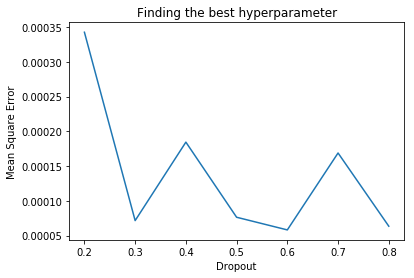

In [70]:
min_val = min(dropout_result.values())
min_val_key = [k for k, v in dropout_result.items() if v == min_val]
print (dropout_result)
print (min_val_key)
lists = sorted(dropout_result.items())
x,y = zip(*lists)
plt.plot(x,y)
plt.title('Finding the best hyperparameter')
plt.xlabel('Dropout')
plt.ylabel('Mean Square Error')
plt.show()

In [72]:
stock_name = '399300'
seq_len = 22
d = 0.3
shape = [4, seq_len, 1] # feature, window, output
neurons = [128, 128, 32, 1]
epochslist = [10,20,30,40,50,60,70,80,90,100]

In [73]:
epochs_result = {}

for epochs in epochslist:    
    trainScore, testScore = quick_measure(stock_name, seq_len, d, shape, neurons, epochs)
    epochs_result[epochs] = testScore

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 22, 128)           68096     
_________________________________________________________________
dropout_17 (Dropout)         (None, 22, 128)           0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 33        
Total params: 203,841
Trainable params: 203,841
Non-trainable params: 0
_________________________________________________________________
Trai

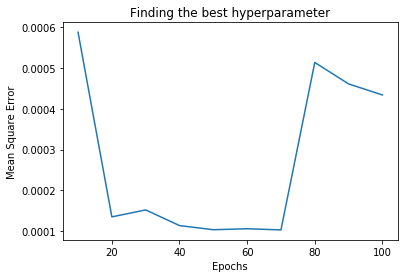

In [74]:
lists = sorted(epochs_result.items())
x,y = zip(*lists)
plt.plot(x,y)
plt.title('Finding the best hyperparameter')
plt.xlabel('Epochs')
plt.ylabel('Mean Square Error')
plt.show()

In [75]:
stock_name = '399300'
seq_len = 22
d = 0.3
shape = [4, seq_len, 1] # feature, window, output
neurons = [128, 128, 32, 1]
epochs = 70

In [76]:
neuronlist1 = [32, 64, 128, 256, 512]
neuronlist2 = [16, 32, 64]
neurons_result = {}

for neuron_lstm in neuronlist1:
    neurons = [neuron_lstm, neuron_lstm]
    for activation in neuronlist2:
        neurons.append(activation)
        neurons.append(1)
        trainScore, testScore = quick_measure(stock_name, seq_len, d, shape, neurons, epochs)
        neurons_result[str(neurons)] = testScore
        neurons = neurons[:2]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_37 (LSTM)               (None, 22, 32)            4736      
_________________________________________________________________
dropout_37 (Dropout)         (None, 22, 32)            0         
_________________________________________________________________
lstm_38 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_38 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 17        
Total params: 13,601
Trainable params: 13,601
Non-trainable params: 0
_________________________________________________________________
Train 

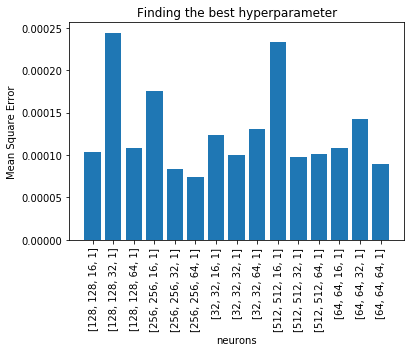

In [77]:
lists = sorted(neurons_result.items())
x,y = zip(*lists)

plt.title('Finding the best hyperparameter')
plt.xlabel('neurons')
plt.ylabel('Mean Square Error')

plt.bar(range(len(lists)), y, align='center')
plt.xticks(range(len(lists)), x)
plt.xticks(rotation=90)

plt.show()

In [80]:
stock_name = '399300'
seq_len = 22
d = 0.3
shape = [4, seq_len, 1] # feature, window, output
neurons = [256, 256, 64, 1]
epochs = 70
decaylist = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [81]:
#df = get_stock_data(stock_name)
def build_model3(layers, neurons, d, decay):
    model = Sequential()
    
    model.add(LSTM(neurons[0], input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(neurons[1], input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))
    # model = load_model('my_LSTM_stock_model1000.h5')
    adam = keras.optimizers.Adam(decay=decay)
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model
def quick_measure(stock_name, seq_len, d, shape, neurons, epochs, decay):
    X_train, y_train, X_test, y_test = load_data(df, seq_len)
    model = build_model3(shape, neurons, d, decay)
    model.fit(X_train, y_train, batch_size=512, epochs=epochs, validation_split=0.1, verbose=1)
    # model.save('LSTM_Stock_prediction-20170429.h5')
    trainScore, testScore = model_score(model, X_train, y_train, X_test, y_test)
    return trainScore, testScore
decay_result = {}
for decay in decaylist:    
    trainScore, testScore = quick_measure(stock_name, seq_len, d, shape, neurons, epochs, decay)
    decay_result[decay] = testScore

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_67 (LSTM)               (None, 22, 256)           267264    
_________________________________________________________________
dropout_67 (Dropout)         (None, 22, 256)           0         
_________________________________________________________________
lstm_68 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_68 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_68 (Dense)             (None, 1)                 65        
Total params: 809,089
Trainable params: 809,089
Non-trainable params: 0
_________________________________________________________________
Trai

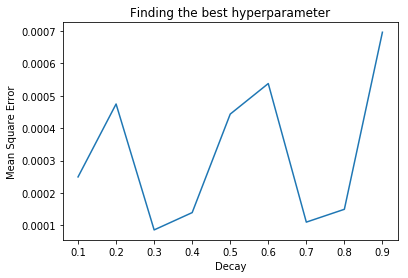

In [82]:
lists = sorted(decay_result.items())
x,y = zip(*lists)
plt.plot(x,y)
plt.title('Finding the best hyperparameter')
plt.xlabel('Decay')
plt.ylabel('Mean Square Error')
plt.show()

In [84]:
stock_name = '399300'
seq_len = 22
d = 0.3
neurons = [256, 256, 64, 1]
epochs = 70
decay = 0.3

In [85]:
seq_len_list = [5, 10, 22, 60, 120, 180]

seq_len_result = {}

for seq_len in seq_len_list:
    shape = [4, seq_len, 1]
    
    trainScore, testScore = quick_measure(stock_name, seq_len, d, shape, neurons, epochs, decay)
    seq_len_result[seq_len] = testScore

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_85 (LSTM)               (None, 5, 256)            267264    
_________________________________________________________________
dropout_85 (Dropout)         (None, 5, 256)            0         
_________________________________________________________________
lstm_86 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_86 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_85 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_86 (Dense)             (None, 1)                 65        
Total params: 809,089
Trainable params: 809,089
Non-trainable params: 0
_________________________________________________________________
Trai

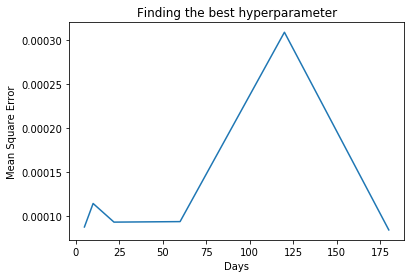

In [86]:
lists = sorted(seq_len_result.items())
x,y = zip(*lists)
plt.plot(x,y)
plt.title('Finding the best hyperparameter')
plt.xlabel('Days')
plt.ylabel('Mean Square Error')
plt.show()